# Inspired from Tutorial2-MapMaking-QUBICPlanck-Multichromatic.Rmd written by Mathias Régnier
JCH - 20 Jan 2023

In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
%matplotlib inline

# %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))



In [2]:
nside = 256
relative_bandwidth = 0.25
band = 220
band_planck = 217
seed = 42
noiseless = False
rwplanck = 1.
tol = 1e-4

npointings = 3000
Nf_TOD = 20
Nf_recon = 2
fact_sub = 15

# TOD Fabrication

In [3]:
reload(Acq)

# Repository for dictionary
global_dir = Qubic_DataDir()
print(global_dir)
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d_TOD = qubic.qubicdict.qubicDict()
d_TOD.read_from_file(dictfilename)

d_TOD['nf_recon'] = Nf_TOD
d_TOD['nf_sub'] = Nf_TOD
d_TOD['nside'] = nside
npix=12*d_TOD['nside']**2
d_TOD['RA_center'] = 0
d_TOD['DEC_center'] = -57
center = qubic.equ2gal(d_TOD['RA_center'], d_TOD['DEC_center'])
d_TOD['effective_duration'] = 3
d_TOD['npointings'] = npointings
d_TOD['tol'] = 5e-4
d_TOD['filter_nu'] = band * 1e9
d_TOD['photon_noise'] = not noiseless
d_TOD['noiseless'] = noiseless
d_TOD['config'] = 'FI'
d_TOD['MultiBand'] = True
d_TOD['planck'] = True

print('*************** Noise **************')
print('Noisless:      {}'.format(d_TOD['noiseless']))
print('Photon Noise:  {}'.format(d_TOD['photon_noise']))
print('************************************')

Qubic_sky = qss.Qubic_sky({'cmb':seed, 'Dust':'d0'}, d_TOD)
mapin_TOD = Qubic_sky.get_simple_sky_map()

# QUBIC Acquisition
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)

H_TOD = qubic_acquisition.get_operator(convolution=True)
n = qubic_acquisition.get_noise()
if noiseless == True:
    n *= 0

tod = H_TOD(mapin_TOD) + n

### Free Memory
del H_TOD, qubic_acquisition, n
gc.collect()

/Users/hamilton/Python/GitQubic/qubic/qubic/
*************** Noise **************
Noisless:      False
Photon Noise:  True
************************************


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (297

34372

(20, 786432, 3)


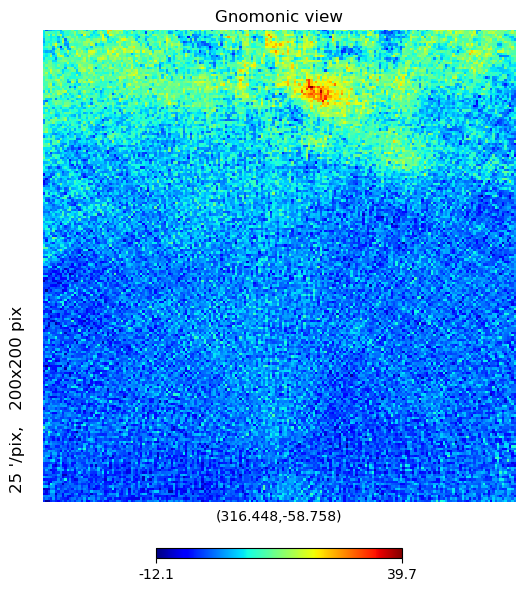

In [4]:
print(np.shape(mapin_TOD))
hp.gnomview(mapin_TOD[0,:,1], rot=center, reso=25, cmap='jet')

# Reconstruction

In [5]:
reload(Acq)

d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon
Qubic_sky = qss.Qubic_sky({'cmb':seed, 'Dust':'d0'}, d_formaps)
mapin = Qubic_sky.get_simple_sky_map()
print(np.shape(mapin))


d = copy.deepcopy(d_TOD)
# d['nf_recon'] = Nf_recon
# d['nf_sub'] = d['nf_recon'] * fact_sub

# QUBIC Acquisition
qubic_acquisition = Acq.QubicIntegrated(d, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)
cov = qubic_acquisition.get_coverage()
qubic_final_fwhm = list(qubic_acquisition.final_fwhm)

# Planck Acquisition
mapin_conv = mapin.copy()

for i in range(Nf_recon):
    print(qubic_acquisition.final_fwhm[i])
    C = HealpixConvolutionGaussianOperator(fwhm=qubic_acquisition.final_fwhm[i])
    mapin_conv[i] = C(mapin[i])
print(mapin_conv.shape)

planck_acquisition = Acq.PlanckAcquisition(band_planck, qubic_acquisition.scene)


# Joint Acquisition
qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)
del qubic_acquisition, planck_acquisition
gc.collect()

H = qubicplanck_acquisition.get_operator(convolution=False, convolve_to_max=False)

invntt = qubicplanck_acquisition.get_invntt_operator(weight_planck=rwplanck, beam_correction=qubic_final_fwhm)
# invntt = qubicplanck_acquisition.get_invntt_operator(weight_planck=rwplanck)
# invntt = qubicplanck_acquisition.get_invntt_operator()

H

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


(2, 786432, 3)
You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
0.005018490564456313
0.0044258926634918585
(2, 786432, 3)
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB

1
corrected by 2.7895054008173163


BlockRowOperator([
    BlockColumnOperator([
        CompositionOperator([
            ReshapeOperator((992,3000), 2976000),
            AdditionOperator([
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, shapein=(992,3000), shapeout=(992,3000)),
                    DiagonalOperator(array([0.0003271690115564286, ..., 0.0003271690115564286], dtype=float64), broadcast='rightward'),
                    ReshapeOperator((992,3000,1), (992,3000)),
                    DenseBlockDiagonalOperator(array([[[[1.6780689164531536e-21, ..., -1.4532503109494574e-21]]]], dtype=float64), naxesin=1, naxesout=1, shapein=(992,3000,3), shapeout=(992,3000,1)),
                    ProjectionOperator(None, shapein=(786432,3), shapeout=(992,3000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, shapein=(992,3000), shapeout=(992,3000)),
                    DiagonalOperator(array([0.0003268309561723

In [6]:
qubicplanck_acquisition.get_invntt_operator

<bound method QubicPlanckMultiBandAcquisition.get_invntt_operator of <Acquisition.QubicPlanckMultiBandAcquisition object at 0x15f632ee0>>

In [7]:
### Replacing fake QUBIC TOD with real one
n = qubicplanck_acquisition.get_noise()
if noiseless == True:
    n *= 0

mytod = H(mapin_conv) + n

nelt = len(np.ravel(tod))
mytod[:nelt] = np.ravel(tod)

### Solve PCG
H = qubicplanck_acquisition.get_operator(convolution=False)
A = H.T * invntt * H
b = H.T * invntt * mytod

def get_preconditioner(cov):
    if cov is not None:
        cov_inv = 1 / cov
        cov_inv[np.isinf(cov_inv)] = 0.
        preconditioner = DiagonalOperator(cov_inv, broadcast='rightward')
    else:
        preconditioner = None
    return preconditioner


M = Acq.get_preconditioner(np.ones(12*d['nside']**2))


solution_qubic_planck = pcg(A, b, x0=None, M=M, tol=tol, disp=True, maxiter=200)

del H, M, A, b, n, mytod, invntt, qubicplanck_acquisition
gc.collect()

Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcdhcp3.in2p3.fr: Allo

8398

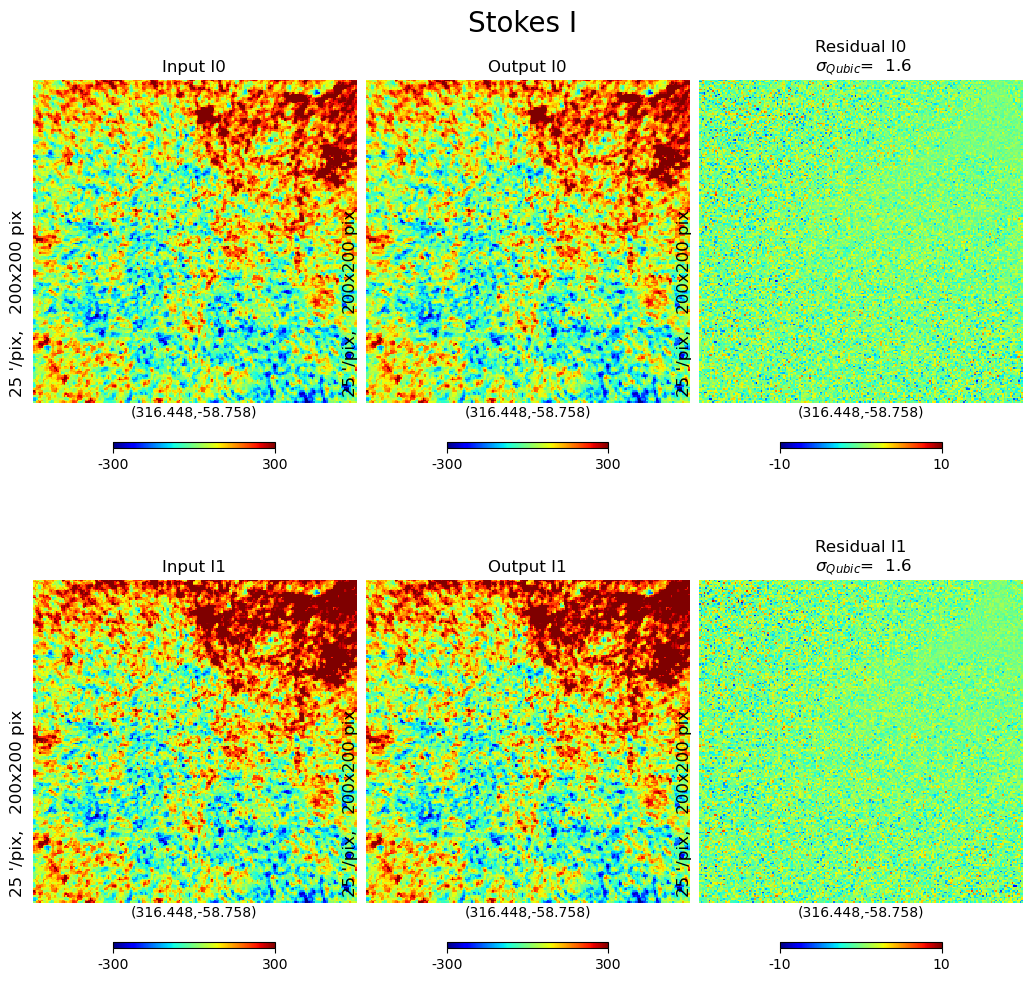

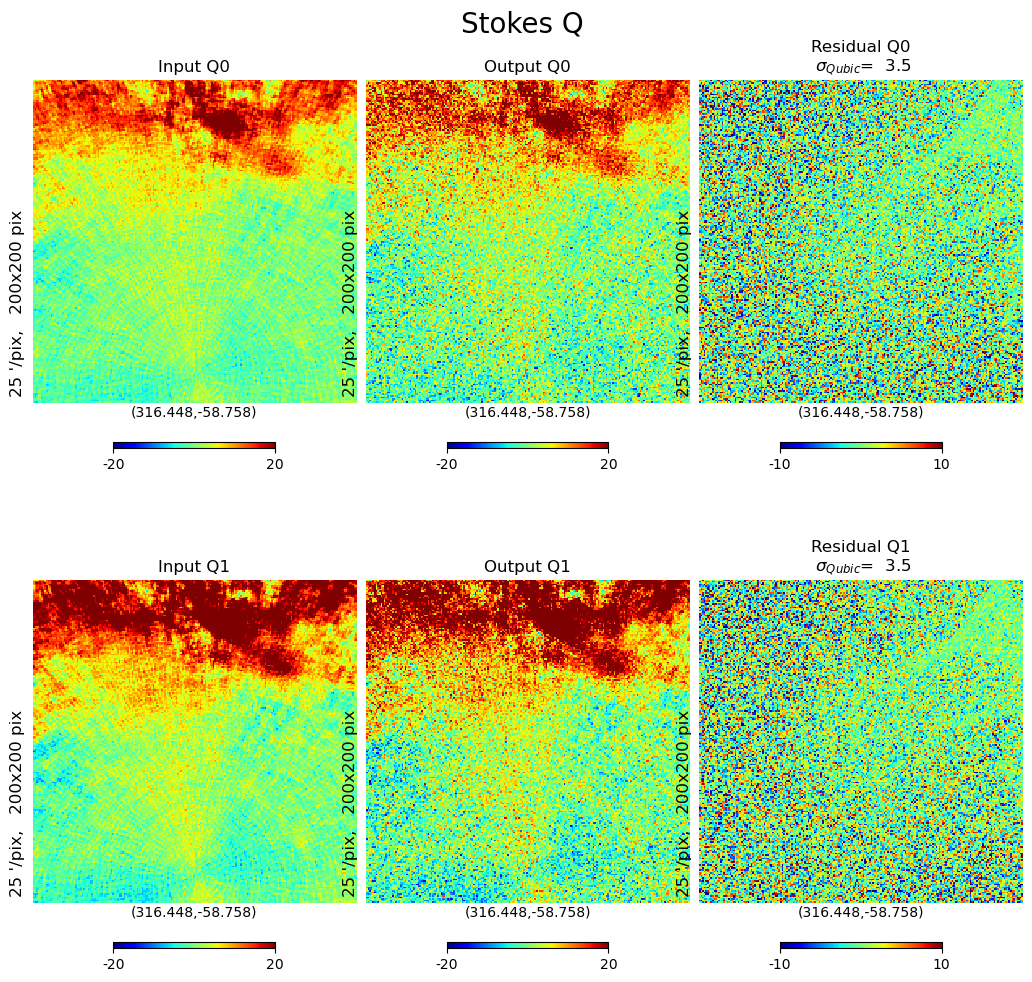

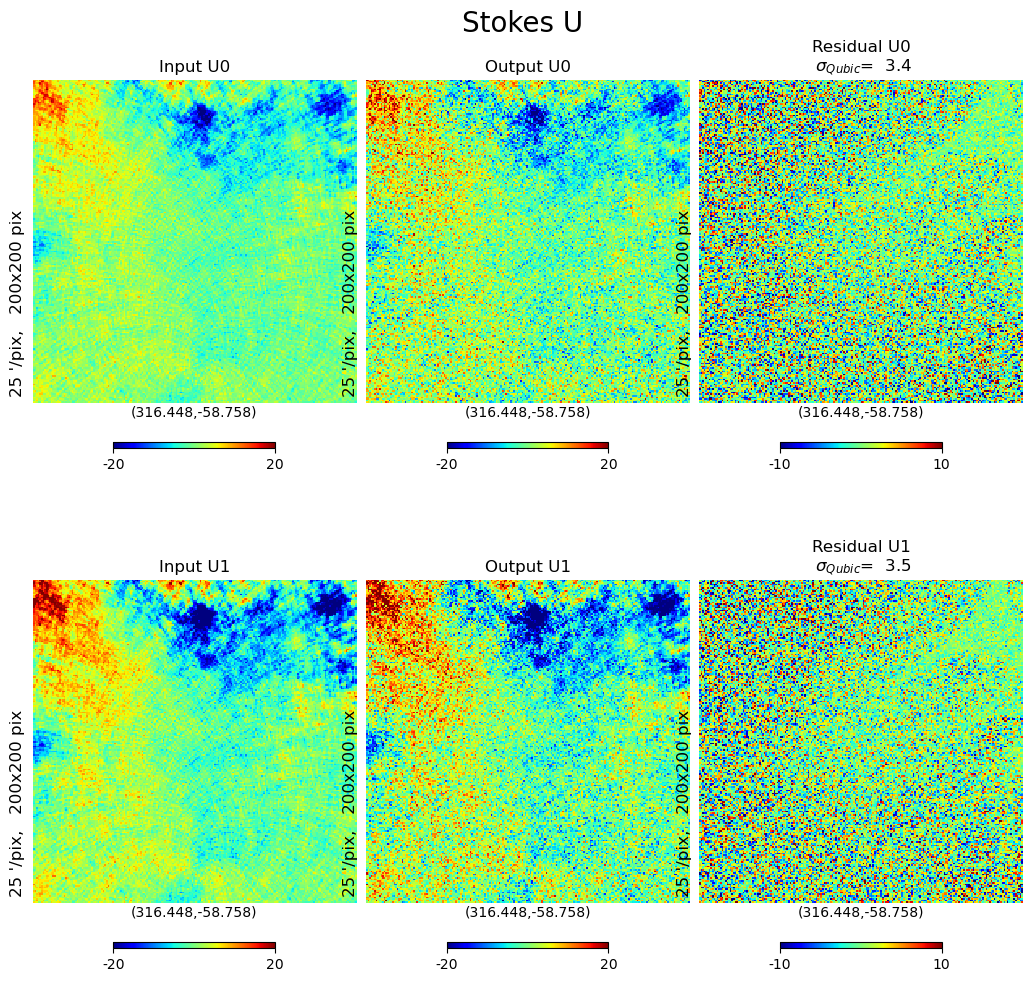

RMS In:
Mean
[1.61391078 3.47641402 3.46634603]

RMS Out:
Mean
[2.06471226 4.62357161 4.62660809]


In [8]:
def display_maps(inputs, outputs, istk, display=True, rot=None, res=None, min=300, max=300, minr=-300, maxr=300, 
                 extra_string='', addnum=False, inside=None):
    
    r = inputs[:, :, istk] - outputs[:, :, istk]
    Nf = outputs.shape[0]
    
    all_rms_in = np.zeros(Nf)
    all_rms_out = np.zeros(Nf)
    
    stk=['I', 'Q', 'U']
    k=1
    for i in range(Nf): # Nf
        if addnum:
            addstr = '{}'.format(i)
        else:
            addstr=''
        if inside is not None:
            rms_in = np.std(r[i][inside])
            rms_out = np.std(r[i][~inside])
            all_rms_in[i] = rms_in
            all_rms_out[i] = rms_out
            addin = '\n $\sigma_{Qubic}$='+'{0:5.2g}'.format(rms_in)
        else:
            addin = ''
        hp.gnomview(inputs[i, :, istk], rot=rot, reso=res, cmap='jet', min=min, max=max, sub=(Nf, 3, k), title='Input'+ extra_string+addstr)
        k+=1
        hp.gnomview(outputs[i, :, istk], rot=rot, reso=res, cmap='jet', min=min, max=max, sub=(Nf, 3, k), title='Output'+ extra_string+addstr)
        k+=1
        hp.gnomview(r[i], rot=rot, reso=res, cmap='jet', min=minr, max=maxr, sub=(Nf, 3, k), title='Residual'+ extra_string+addstr+addin)
        k+=1
        
    return all_rms_in, all_rms_out


all_rms_in = np.zeros((d['nf_recon'], 3))
all_rms_out = np.zeros((d['nf_recon'], 3))
inside = (cov/np.max(cov)) >= 0.01
stk = ['I', 'Q', 'U']
for i in range(3):
    fig = plt.figure(figsize=(10, 10))
    mm = 20
    mmr = mm/2
    if i==0:
        mm=300
        mmr = 10
    rin, rout = display_maps(mapin_conv, solution_qubic_planck['x'], istk=i, display=True, rot=center, res=25, 
                 min=-mm, max=mm, minr=-mmr, maxr=mmr, extra_string=' {}'.format(stk[i]), addnum=True, inside=inside)
    all_rms_in[:,i] = rin
    all_rms_out[:,i] = rout
    fig.suptitle('Stokes {}'.format(stk[i]), fontsize=20)
    tight_layout()
    plt.show()
    
print('RMS In:')
#print(all_rms_in)
print('Mean')
print(np.mean(all_rms_in, axis=0))
print()
print('RMS Out:')
#print(all_rms_out)
print('Mean')
print(np.mean(all_rms_out, axis=0))

In [9]:
print(fact_sub)

15


# Check nsub_fact

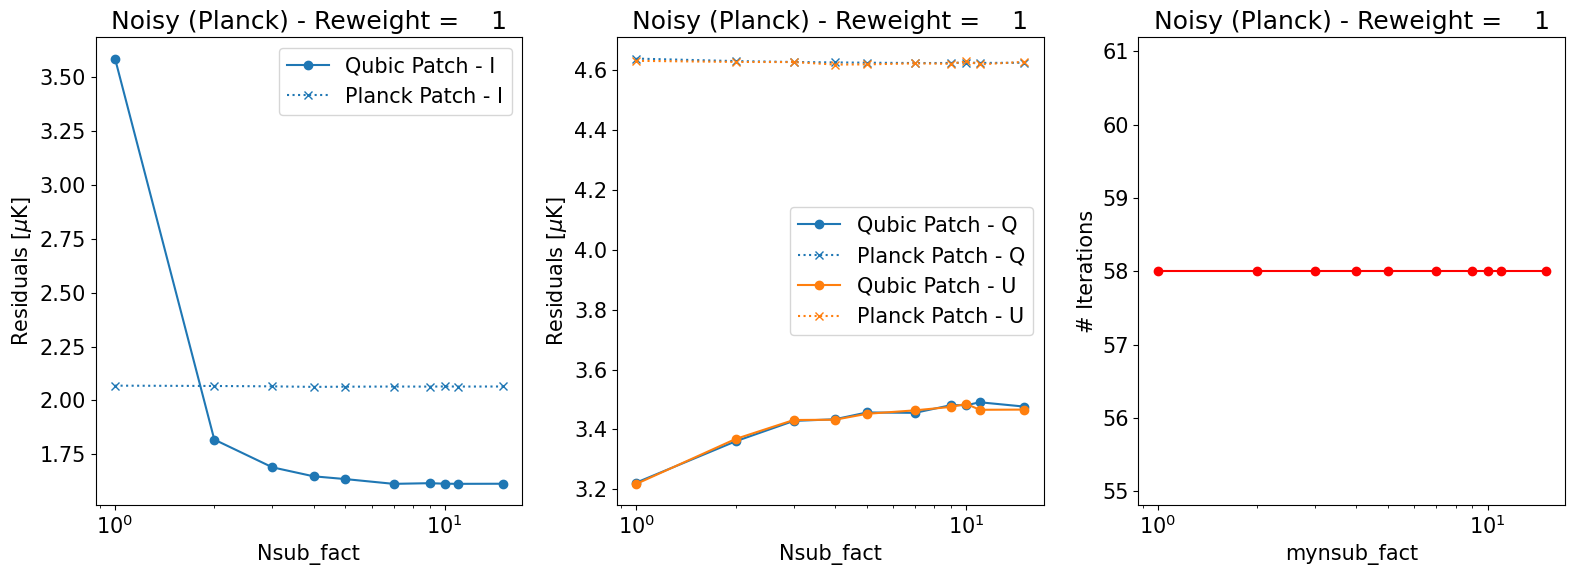

In [21]:
rc('figure', figsize=(16, 6))
rc('font', size=15)

### With tol = 1e-4 Noisy - Nrec = 2 - NsubTOD=20 - reweight=1
mynsub_fact = [1, 2, 3, 4, 5, 7, 9, 10, 11, 15]
reweight = 1
niter = [58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
mres_in = np.array([
    [3.58472457, 3.22298455, 3.21855201],
    [1.81866973, 3.36066221, 3.36840398],
    [1.69008923, 3.42854864, 3.4316211 ],
    [1.64837593 ,3.43409182, 3.43252245],
    [1.6354497,  3.45680513, 3.45231226],
    [1.61334541, 3.4555319,  3.46385262],
    [1.61647737, 3.48128748, 3.47539694],
    [1.61414489, 3.48084573, 3.48539108],
    [1.61345363, 3.49078798, 3.46570593],
    [1.61391078, 3.47641402, 3.46634603]
])
mres_out = np.array([
    [2.06859773, 4.63752262, 4.63005879],
    [2.06709689, 4.6292042,  4.6264031 ],
    [2.0653792,  4.62623514, 4.62591536],
    [2.06289662, 4.62479276, 4.61757402],
    [2.06381216, 4.62382751, 4.61823292],
    [2.06450987, 4.6227041,  4.62162905],
    [2.06421822, 4.62288396, 4.62014479],
    [2.06496684, 4.62441156, 4.62794441],
    [2.06438636, 4.62311894, 4.61827888],
    [2.06471226, 4.62357161, 4.62660809]
])

subplot(1,3,1)
for i in range(1):
    p=plot(mynsub_fact, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(mynsub_fact, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
xscale('log')
xlabel('Nsub_fact')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))

subplot(1,3,2)
for i in range(1,3):
    p=plot(mynsub_fact, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(mynsub_fact, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
xscale('log')
xlabel('Nsub_fact')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))

subplot(1,3,3)
plot(mynsub_fact, niter, 'ro-')
xscale('log')
xlabel('mynsub_fact')
ylabel('# Iterations')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))
tight_layout()

# Check npointings

# Check 150 and 220

# Check Tol

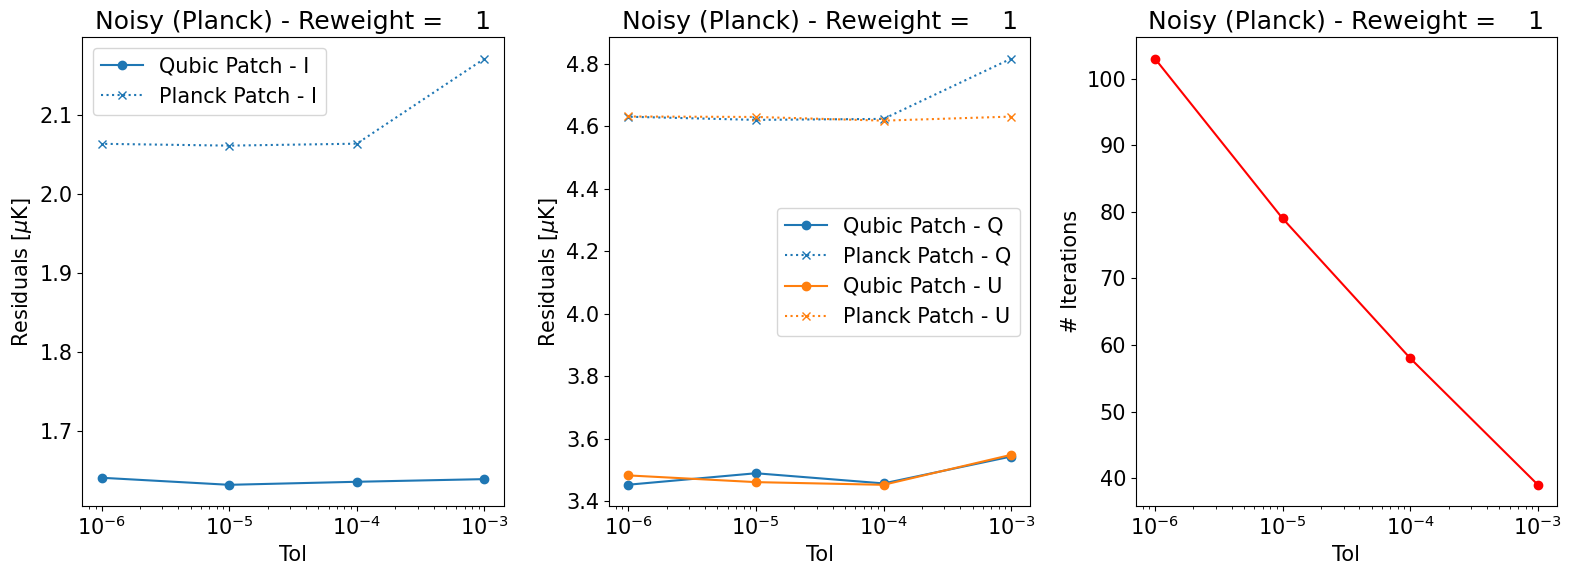

In [11]:
rc('figure', figsize=(16, 6))
rc('font', size=15)

### With nrec = 1e-4 Noisy - Nrec = 2 - fact_sub = 5 - NsubTOD=20
mytol = [1e-3, 1e-4, 1e-5, 1e-6]
reweight = 1
niter = [39, 58, 79, 103]
mres_in = np.array([
    [1.63880836, 3.54294926, 3.54834288],
    [1.6354497,  3.45680513, 3.45231226],
    [1.63159892, 3.48933444, 3.46092587],
    [1.64053454, 3.45261348, 3.48240437]
])
mres_out = np.array([
    [2.17156379, 4.81671748, 4.63116656],
    [2.06381216, 4.62382751, 4.61823292],
    [2.06135581, 4.62063808, 4.62999084],
    [2.06366355, 4.63076347, 4.63154723]
])

subplot(1,3,1)
for i in range(1):
    p=plot(mytol, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(mytol, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
xscale('log')
xlabel('Tol')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))

subplot(1,3,2)
for i in range(1,3):
    p=plot(mytol, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(mytol, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
xscale('log')
xlabel('Tol')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))

subplot(1,3,3)
plot(mytol, niter, 'ro-')
xscale('log')
xlabel('Tol')
ylabel('# Iterations')
title('Noisy (Planck) - Reweight = {0:4.1g}'.format(reweight))

tight_layout()

# Check Planck reweighting - it should be 1

Text(0.5, 1.0, 'Noisy (Planck) - Tol = 0.0001')

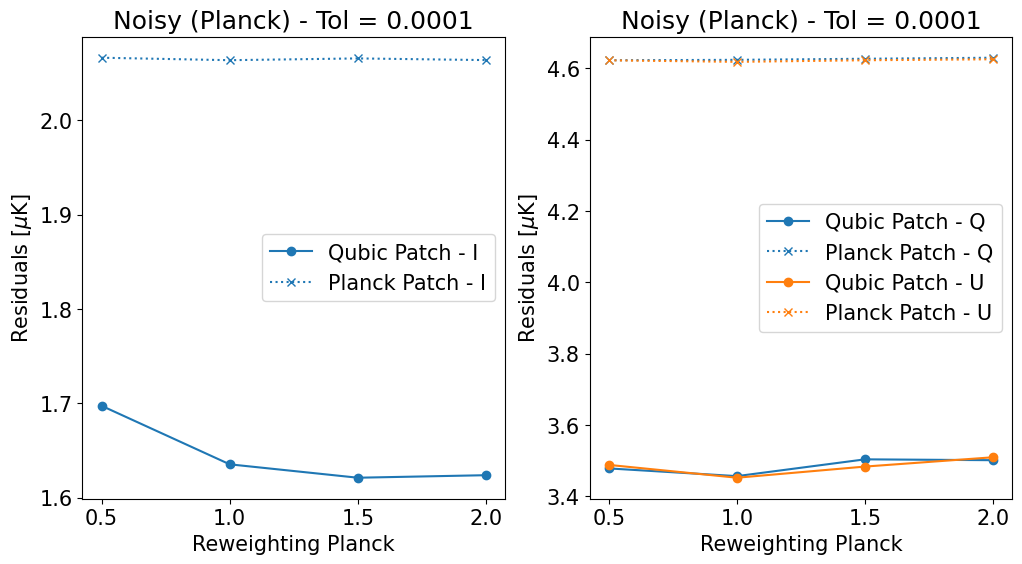

In [12]:
rc('figure', figsize=(12, 6))
rc('font', size=15)

### With tol = 1e-4 Noisy - Nrec = 2 - fact_sub = 5 - NsubTOD=20
mytol = 1e-4
reweight = [0.5, 1, 1.5, 2.]
niter = [58, 58, 58, 58]
mres_in = np.array([
    [1.69746905, 3.47838217, 3.48822812],
    [1.6354497,  3.45680513, 3.45231226],
    [1.6212544,  3.50385103, 3.48359045],
    [1.62392819, 3.50143686, 3.5096837 ]
])
mres_out = np.array([
    [2.0664305 , 4.62262181, 4.62250416],
    [2.06381216, 4.62382751, 4.61823292],
    [2.06569455, 4.62687962, 4.62268223],
    [2.06391871, 4.62977234, 4.62542979]
])

subplot(1,2,1)
for i in range(1):
    p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
#xscale('log')
xlabel('Reweighting Planck')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Tol = {0:4.1g}'.format(mytol))

subplot(1,2,2)
for i in range(1,3):
    p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
    plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
legend()
#yscale('log')
#xscale('log')
xlabel('Reweighting Planck')
ylabel('Residuals [$\mu$K]')
title('Noisy (Planck) - Tol = {0:4.1g}'.format(mytol))


In [13]:
##### This is without the Planck variance calculated after reconvolution to the QUBIC beam
#####
#####  => Wrong => do not use
#####
# rc('figure', figsize=(12, 6))
# rc('font', size=15)

# ### With tol = 1e-4 Noisy 
# mytol = 1e-4
# reweight = [0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 10]
# niter = [97, 59, 57, 57, 57, 56, 56, 57, 56, 56]
# mres_in = np.array([
#     [4.23942255, 7.45563746, 7.45175413],
#     [2.80569564, 5.47680431, 5.47312766],
#     [2.75615575, 5.42526101, 5.40740284],
#     [2.70712256, 5.38005623, 5.4004576 ],
#     [2.68855504, 5.3603375,  5.35420697],
#     [2.67133004, 5.36795749, 5.36417268],
#     [2.65579637, 5.37264432, 5.36711852],
#     [2.63244387, 5.41573105, 5.41183055],
#     [2.63222223, 5.46984759, 5.46136405],
#     [2.72194743, 5.95325714, 5.92407007]

# ])
# mres_out = np.array([
#     [3.44448705, 7.7226945,  7.70689691],
#     [3.44602303, 7.70717078, 7.70452179],
#     [3.44529289, 7.71228795, 7.71439157],
#     [3.44784219, 7.70898994, 7.70699893],
#     [3.44372142, 7.71307698, 7.71186852],
#     [3.44543254, 7.71068326, 7.72206763],
#     [3.44440274, 7.71329574, 7.70871337],
#     [3.44919027, 7.7219526,  7.71415519],
#     [3.45250623, 7.71160867, 7.71094258],
#     [3.44658145, 7.70735915, 7.71360501]
# ])

# subplot(1,2,1)
# for i in range(1):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# legend()
# #yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noisy (Planck) - Tol = {0:4.1g}'.format(mytol))

# subplot(1,2,2)
# for i in range(1,3):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# legend()
# #yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noisy (Planck) - Tol = {0:4.1g}'.format(mytol))


# Below are some tests done with a previous version of the code where the noise in Planck was added after convolving it to QUBIC resolution. So not quite correct.

In [14]:
# ### With tol = 1e-4 Noisy - Planck noise divided by 400
# mytol = 1e-4
# reweight = [0.1, 1, 10, 100, 1000]
# niter = [97, 56, 56, 56, 56]
# mres_in = np.array([
#     [3.81254644, 6.51854425, 6.53347444],
#     [1.06421763, 2.10234087, 2.10054351],
#     [0.16246321, 0.3877733,  0.38600909],
#     [0.02120244, 0.05034531, 0.04880878],
#     [0.01031803, 0.02426569, 0.02137765]

# ])
# mres_out = np.array([
#     [0.09052606, 0.27883026, 0.20844469],
#     [0.05844967, 0.20326536, 0.11607107],
#     [0.05755734, 0.20150016, 0.11399646],
#     [0.05497709, 0.19728848, 0.11178488],
#     [0.05437944, 0.19623116, 0.11123048]
# ])

# for i in range(3):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# plot(reweight, niter, 'ko-', label='Number of iterations')
# legend()
# yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noisy (Planck / 400) - Tol = {0:4.1g}'.format(mytol))


In [15]:
# ### With tol = 1e-4 Noisey
# mytol = 1e-4
# reweight = [0.01, 0.1, 1, 10, 100, 1000]
# niter = [200, 97, 56, 57, 56, 56]
# mres_in = np.array([
#     [ 9.9970657,  17.44124847, 17.43232147],
#     [4.18275855, 7.34424739, 7.36611685],
#     [2.55711377, 5.09562613, 5.12898648],
#     [2.70432068, 5.83191143, 5.85102276],
#     [2.77139025, 6.1758667,  6.19014007],
#     [2.77931681, 6.22069458, 6.23441781]

# ])
# mres_out = np.array([
#     [3.59574741, 7.81677848, 7.68554846],
#     [3.44645661, 7.70857841, 7.7130349 ],
#     [3.44588215, 7.70671659, 7.71144241],
#     [3.44575466, 7.70664927, 7.71170146],
#     [3.44584366, 7.70673218, 7.71154249],
#     [3.44583886, 7.70672399, 7.71154832]
# ])

# for i in range(3):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# plot(reweight, niter, 'ko-', label='Number of iterations')
# legend()
# yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noisy - Tol = {0:4.1g}'.format(mytol))


In [16]:
# ### With tol = 1e-4 Noiseless
# mytol = 1e-4
# reweight = [1, 10, 100, 500, 1000, 10000]
# niter = [102, 56, 56, 56, 56, 56]
# mres_in = np.array([
#     [2.49359258, 0.17458116, 0.16683601],
#     [0.75582086, 0.0653021,  0.0637349 ],
#     [0.12640817, 0.02325559, 0.0202144 ],
#     [0.02988558, 0.01868438, 0.01501354],
#     [0.01674031, 0.01819549, 0.01445107],
#     [0.00751576, 0.01779744, 0.01396574],
# ])
# mres_out = np.array([
#     [0.07401118, 0.21727782, 0.12102851],
#     [0.0576425,  0.20157418, 0.11280883],
#     [0.05692112, 0.20056657, 0.11227749],
#     [0.05496831, 0.19743945, 0.11062845],
#     [0.05403628, 0.19587964, 0.10980314],
#     [0.05355658, 0.19505459, 0.10936589],
# ])

# for i in range(3):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# plot(reweight, niter, 'ko-', label='Number of iterations')
# legend()
# yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noiseless - Tol = {0:4.1g}'.format(mytol))


In [17]:
# ### With Tol = 1e-3 - Noiseless
# mytol_2 = 1e-3
# reweight_2 = [1, 10, 100, 500, 1000, 10000]
# niter_2 = [69, 38, 37, 37, 37, 37]
# mres_in_2 = np.array([
#     [2.50540939, 0.18745416, 0.17817012],
#     [0.76756676, 0.12393673, 0.11366435,], 
#     [0.16107347, 0.12313865, 0.10691409],
#     [0.09457047, 0.12786731, 0.11430455],
#     [0.09017839, 0.12872143, 0.1155565],
#     [0.08810493, 0.12947184, 0.11662834]
# ])
# mres_out_2 = np.array([
#     [0.78676898, 1.57117326, 0.7669496 ],
#     [0.60268751, 1.34802079, 0.65567135],
#     [0.73230228, 1.49685491, 0.72969402],
#     [0.73225673, 1.49615093, 0.72933654],
#     [0.7322305,  1.49611277, 0.72931773],
#     [0.73221107, 1.49609637, 0.72930985]
# ])

# for i in range(3):
#     p=plot(reweight_2, mres_in_2[:,i], 'o-', label='Qubic Patch - '+stk[i])
#     plot(reweight_2, mres_out_2[:,i], 'x:', color=p[0].get_color(), label='Planck Patch - '+stk[i])
# plot(reweight_2, niter_2, 'ko-', label='Number of iterations')
# legend()
# yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')
# title('Noiseless - Tol = {0:4.1g}'.format(mytol_2))


In [18]:
# for i in range(3):
#     p=plot(reweight_2, mres_in_2[:,i], 'o-', label='Tol = {}'.format(mytol_2)+' Qubic Patch - '+stk[i])
#     plot(reweight_2, mres_out_2[:,i], 'x:', color=p[0].get_color(), label='Tol = {}'.format(mytol_2)+' Planck Patch - '+stk[i])
# plot(reweight_2, niter_2, 'ko-', label='Number of iterations Tol = {}'.format(mytol))
# for i in range(3):
#     p=plot(reweight, mres_in[:,i], 'o-', label='Tol = {}'.format(mytol)+' Qubic Patch - '+stk[i])
#     plot(reweight, mres_out[:,i], 'x:', color=p[0].get_color(), label='Tol = {}'.format(mytol)+' Planck Patch - '+stk[i])
# plot(reweight, niter, 'ko-', label='Number of iterations Tol = {}'.format(mytol))

# legend(fontsize=8)
# yscale('log')
# xscale('log')
# xlabel('Reweighting Planck')
# ylabel('Residuals [$\mu$K]')


<!-- Test de residus QUBIC Patch avec Tol et Nsub_each=5:
- Tol = 1e-2 => 3.4, 0.5, 0.5
- Tol = 5e-3 => 2.7, 0.4, 0.35
- Tol = 3e-3 => 2.6, 0.3, 0.3
- Tol = 2e-3 => 2.5, 0.2, 0.2
- Tol = 1e-3 => 2.5, 0.18, 0.17
- Tol = 5e-4 => 2.5, 0.18, 0.17
- Tol = 1e-4 => 2.5, 0.18, 0.17 -->

In [19]:
# tols = [1e-2, 5e-3, 3e-3, 2e-3, 1e-3, 5e-4, 1e-4]
# resI = [3.4, 2.7, 2.6, 2.5, 2.5, 2.5, 2.5]
# resQ = [0.5, 0.4, 0.3, 0.2, 0.18, 0.18, 0.18]
# resU = [0.5, 0.35, 0.3, 0.2, 0.17, 0.17, 0.17]

# plot(tols, resI, 'ro-', label='Residuals I')
# plot(tols, resQ, 'bo-', label='Residuals Q')
# plot(tols, resU, 'go-', label='Residuals U')
# legend()
# xlabel('Tol')
# ylabel('Residuals in QUBIC Patch [$\mu$K]')
# yscale('log')
# xscale('log')


in TOD: convolution=True, Nsub=20

in Recon 2: Planck maps reconvolved to recon reso but not to each sub-band reso

Tol = 1e-4

RMS in I,Q,U:
- nsub_each = 1  => 13, 0.8, 0.8
- nsub_each = 5  => 2.5, 0.18, 0.17
- nsub_each = 9 => 1.5, 0.12, 0.11
- nsub_each = 10 => 0.44, 0.06, 0.06 !! = Nbre de sous bandes pour fabrication des TOD
- nsub_each = 11 => 1.4, 0.11, 0.1   !! Juste un peu plus
- nsub_each = 15 => 1.3, 0.1, 0.1    !! 1.5 foix plus de bandes que dans la création des TOD
- nsub_each = 20 => 1.2, 0.1, 0.1    !! 2 fois plus de bandes que dans la création du TOD

In [20]:
# nsub_each = [1, 5, 9, 10, 11, 15, 20]
# resI = [13., 2.5, 1.5, 0.44, 1.4, 1.3, 1.2]
# resQ = [0.8, 0.18, 0.12, 0.06, 0.11, 0.1, 0.1]
# resU = [0.8, 0.17, 0.11, 0.06, 0.1, 0.1, 0.1]

# plot(nsub_each, resI, 'ro-', label='Residuals I')
# plot(nsub_each, resQ, 'bo-', label='Residuals Q')
# plot(nsub_each, resU, 'go-', label='Residuals U')
# axvline(x=10, ls='--', color='k', label='Used for TOD synthesis')
# legend()
# xlabel('Nb sub-bands per reco band')
# ylabel('Residuals in QUBIC Patch [$\mu$K]')
# yscale('log')
